관련 패키지 설치

In [4]:
!pip install opencv-python
!pip install cmake
!pip install dlib

     |████████████████████████████████| 49.4 MB 12.0 MB/s eta 0:00:01
You should consider upgrading via the '/home/aiffel0042/anaconda3/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 18.2 MB 11.8 MB/s eta 0:00:01
You should consider upgrading via the '/home/aiffel0042/anaconda3/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 3.2 MB 889 kB/s eta 0:00:01
  Created wheel for dlib: filename=dlib-19.21.0-cp37-cp37m-linux_x86_64.whl size=4180867 sha256=8b69823b4164b1e40c8af427c68741c2f2709adeec6e997084f7ee00cdfb2b7b
  Stored in directory: /home/aiffel0042/.cache/pip/wheels/d8/8f/ac/70af71fd636fb03b238ca3f183e64f5dfdb5e4ffffeff89ce6
Successfully built dlib
You should consider upgrading via the '/home/aiffel0042/anaconda3/bin/python3 -m pip install --upgrade pip' command.


## 라이브러리 불러오기

In [37]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

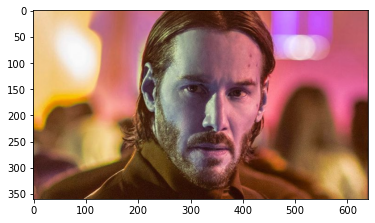

In [38]:
import os
my_image_path = os.getenv('HOME')+'/project/E10/images/image.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

opencv는 특이하게 이미지 색상 정보를 BGR 순으로 사용한다. 그래서 RGB 값이 BGR로 들어가기 때문에 색상이 달라진다.  
그래서 opencv에서 다룬 이미지를 다른 이미지 라이브러리를 이용할 때에는 색깔 보정처리를 해줘야한다.

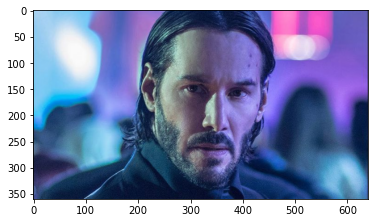

In [39]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

영상처리에서 opencv는 아주 강력하다.  
<li><a href='https://opencv-python.readthedocs.io/en/latest/doc/01.imageStart/imageStart.html'>이미지 다루기 - gramman 0.1 documentation</a></li>

## 10-3 얼굴 검출 face detection
Object detection 기술을 이용해서 얼굴의 위치를 찾아보자  
dlib의 face detector는 HOG(Histogram of Oriented gradient) feature를 사용해서 SVM의 sliding window로 얼굴을 찾는다. HOG와 SVM의 자세한 알고리즘은 아래 링크를 참고해 줘.  
- <li><a href='https://medium.com/@jongdae.lim/%EA%B8%B0%EA%B3%84-%ED%95%99%EC%8A%B5-machine-learning-%EC%9D%80-%EC%A6%90%EA%B2%81%EB%8B%A4-part-4-63ed781eee3c'>딥러닝(Deep Learning)을 사용한 최신 얼굴 인식(Face Recognition)</a></li>  
<li><a href = 'https://medium.com/@ageitgey/machine-learning-is-fun-part-4-modern-face-recognition-with-deep-learning-c3cffc121d78'>Machine Learning is Fun! Part 4: Modern Face Recognition with Deep Learning</a></li>

---
그럼 dlib을 활용해 HOG detector를 선언해보자

In [40]:
import dlib
detector_hog = dlib.get_frontal_face_detector()

In [41]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb,1) #- (image, num of img pyramid)

detecotr_hog의 두 번째 파라미터는 이미지 피라미드의 수이다. 이미지를 upsampling방법을 통해 크기를 키우는 것을 이미지 피라미드라고 한다. 이미지 피라미드에서 얼굴을 다시 검출하면 작게 촬영된 얼굴을 크게 볼 수 있기 때문에 더 정확한 검출이 가능하다.  
  
참고 https://opencv-python.readthedocs.io/en/latest/doc/14.imagePyramid/imagePyramid.html

찾은 얼굴을 출력해보자

In [42]:
print(type(dlib_rects))

<class '_dlib_pybind11.rectangles'>


rectangles[[(241, 93) (464, 316)]]


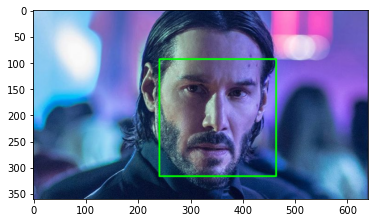

In [43]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

참고 http://dlib.net/python/index.html#dlib.rectangles

## 10-4 얼굴 랜드마크 face landmark
얼굴의 이목구비 위치를 추론하는 것을 face landmark localization 기술이라고 한다.  
face landmark는 detection의 결과물인 bounding box로 잘라낸(crop) 얼굴 이미지를 이용한다.  
  
**Object keypoint estimation 알고리즘**  
  
Face landmark와 같이 객체 내부의 점을 찾는 기술을 object keypoint estimation이라고 한다.  
keypoint를 찾는 알고리즘은 크게 2가지로 나누어 진다.  
  
1) top-down ; bounding box를 찾고 내부의 keypoint를 예측
2) bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성  
  
### Dlib landmark localization
---
잘라진 얼굴 이미지에서 아래 68개의 이목구비 위치를 찾는다.  
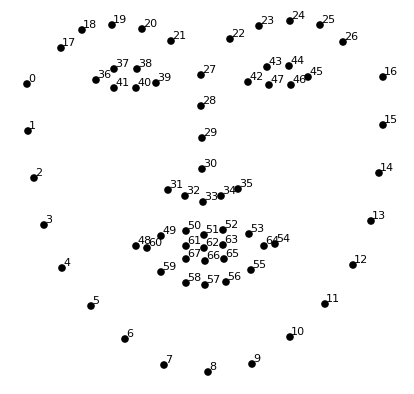  
$$[Dlib에 사용 되는 랜드마크 순서]$$  
  

이 때 점의 개수는 데이터셋과 논문마다 다르다.  

https://www.tugraz.at/institute/icg/research/team-bischof/lrs/downloads/aflw/  
  
```Dlib은 ibug 300-W 데이터셋으로 학습한 pretrained model 을 제공합니다. 학습 알고리즘은 regression tree의 앙상블 모델을 사용 했습니다. 자세한 내용이 궁금하신 분들은 2014년 CVPR (Computer Vision and Pattern Recognition) 에 발표한 논문One Millisecond Face Alignment with an Ensemble of Regression Trees 을 참고해 주세요. 오늘은 알고리즘을 이해하지 않아도 괜찮습니다.```  

https://www.cv-foundation.org/openaccess/content_cvpr_2014/papers/Kazemi_One_Millisecond_Face_2014_CVPR_paper.pdf  
  
Dlib의 제공되는 모델을 사용해보겠습니다. 먼저 공개되어 있는 weight file을 다운로드 받습니다. 위치는 root 디렉토리의 models 디렉토리 입니다. 해당 모델파일은 bz2 압축파일 형태로 제공되어 압축을 풀어준 후 사용하겠습니다.  
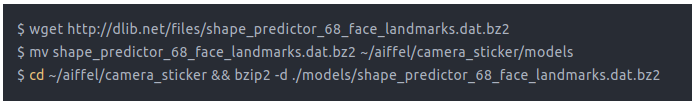

In [44]:
model_path = os.getenv('HOME')+'/project/E10/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

**`landmark_predictor`**는 **`RGB 이미지`**와 **`dlib.rectangle`**을 입력 받아  
**`dlib.full_object_detection`**을 반환한다.

In [45]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p:(p.x,p.y), points.parts()))
    list_landmarks.append(list_points)
    
print(len(list_landmarks[0]))

68


**`points`**는 **`dlib.full_object_detection`**의 객체이기 때문에 **`parts()`** 함수로 개별 위치에 접근할 수 있다. 조금 더 직관적으로 (x,y) 형태로 접근할 수 있도록 변환해 주었다. 따라서 **`list_points`**는 tuple(x,y) 68개로 이루어진 리스트가 된다. 이미지에서 찾아진 얼굴 개수마다 반복하면 **`list_landmark`**에 68개의 랜드마크가 얼굴 개수만큼 저장된다.

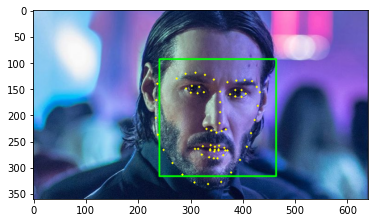

In [46]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 10-5 스티커 적용하기
카메라의 거리에 따라 랜드마크 픽셀 위치가 달라지므로 비율로 계산을 해줘야 한다.  
1. 스티커 위치  
$$ x = x_{nose} $$  
$$ y = y_{nose} - \frac{width}{2}$$  
  

2. 스티커 크기  

$$ width = height = width_{bbox}$$

In [49]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[30]) #nose center index: 30
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print('(x,y):(%d,%d)'%(x,y))
    print('(w,h):(%d,%d)'%(w,h))

(356, 215)
(x,y):(356,103)
(w,h):(224,224)


In [50]:
import os
sticker_path = os.getenv('HOME')+'/project/E10/images/king.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(224, 224, 3)


스티커 좌표 설정 하기  
이미지의 시작점은 top-left란걸 잊지마

In [52]:
refined_x = x - w//2 #left
refined_y = y - h    #top
print('(x,y):(%d,%d)'%(refined_x,refined_y))

(x,y):(244,-121)


y가 음수가 나왔다 즉 원본 이미지의 프레임을 벗어난 것  
음수 범위 예외 처리해줘야함

In [53]:
img_sticker = img_sticker[-refined_y:]
print(img_sticker.shape)

(103, 224, 3)


-y 크기만큼 스티커를 crop한다.  
top의 y좌표는 원본 이미지의 경계 값으로 수정한다.

In [54]:
refined_y = 0
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (244,0)


원본이미지에 스티커 적용하기

In [63]:
sticker_area = img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]=np.where(img_sticker==0,sticker_area, img_sticker).astype(np.uint8)

**`sticker_area`**는 원본이미지에서 스티커를 적용할 위치를 crop한 이미지이다. 예제에서는 **`(566,0)`** 부터 **`(566+268,0+157)`** 범위의 이미지를 의미한다.  
  
스티커 이미지에서 사용할 부분은 0 이 아닌 색이 있는 부분을 사용한다. 다라서 np.where를 통해 img_sticker가 0인 부분은 sticker_area를 사용하고 0이 아닌 부분을 img_sticker를 사용한다.  
  
**`img_show`**에 다시 적용하자

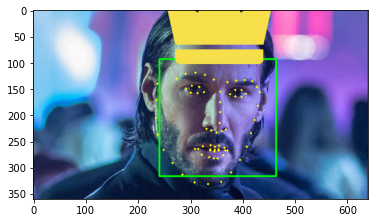

In [64]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

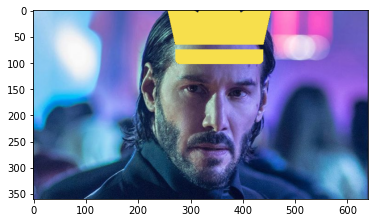

In [65]:
sticker_area = img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()